# This code represents a trading strategy for 1 hour trading intervals
# The predictor is the high price of the Solana cryptocurrency and the minimum threshold is 0.5

In [1]:
################# IMPORTS AND SETUP ##############################


from binance import Client
import pandas as pd
from supporting_functionsM2 import *
from API_KEYS2 import get_keys

# Setting up binance client
KEY, SECRET = get_keys()
client = Client(KEY, SECRET)

# Defining setup variables for creating dataset
# start = "1513724400" # 20.12.2017
start = "1483225200" # 01.01.2017
periods = 101 # approx 8 years
TICKER = "SOLUSDT"
options = ["high", "low", "close", "volume"] # BASE OPTIONS
EPOCHS=5
THRESHOLD=0.5 # Threshold value for lableling, ie. BTCUSDT:close = 0.5 > 0.0 => label = 1, if BTCUSDT:close = -0.5 < 0.0 => 0
PREDICTOR=f"{TICKER}:high"
TIME = f"{TICKER}:time"

In [3]:
################# DOWNLOADING RAW DATA ##########################################

periods = periods
LIMIT = 720 # 720h = 30 days
start1 = start
end1 = next_30_days_unix_timestamp(start1)

############################################ DOWNLOADING DATA ###################################################################### 
data = pd.DataFrame(columns=["time", "open", "high", "low", "close", "volume"])

# downloading the first set of candlestick lines
klines = client.get_historical_klines(TICKER, client.KLINE_INTERVAL_1HOUR, limit=LIMIT, start_str=unix_to_datetime_string(start1, in_milliseconds=False), end_str=unix_to_datetime_string(end1, in_milliseconds=False))
    # print(klines)

# Converting data from list to pandas dataframe
new_data = pd.DataFrame(data=[row[0:6] for row in klines], columns=["time", "open", "high", "low", "close", "volume"])
data = pd.concat([data, new_data], ignore_index=True)

for i in range(periods - 1):
    # Moving the start and end interval to next day
    start1 = next_30_days_unix_timestamp(start1)
    end1 = next_30_days_unix_timestamp(start1) 

    # downloading candlestick lines
    klines = client.get_historical_klines(TICKER, client.KLINE_INTERVAL_1HOUR, limit=LIMIT, start_str=unix_to_datetime_string(start1, in_milliseconds=False), end_str=unix_to_datetime_string(end1, in_milliseconds=False))
    # print(klines)

    # Converting data from list to pandas dataframe
    new_data = pd.DataFrame(data=[row[0:6] for row in klines], columns=["time", "open", "high", "low", "close", "volume"])

    # concatinating the new data with the existing data
    data = pd.concat([data, new_data], ignore_index=True)

# converting all time values from unix to readable string, not important, just for visual purposes and fact checking
data["time"] = data["time"].apply(unix_to_datetime_string) #converting time from 

raw_data = data
display(raw_data)


,time,open,high,low,close,volume
0,2020-08-11 06:00:00,2.85000000,3.47000000,2.85000000,2.95150000,20032.26000000
1,2020-08-11 07:00:00,2.95150000,3.13550000,2.88000000,2.92240000,42069.37000000
2,2020-08-11 08:00:00,2.96260000,3.00000000,2.91440000,2.96000000,24280.76000000
3,2020-08-11 09:00:00,2.96000000,2.97360000,2.85000000,2.85430000,26371.23000000
4,2020-08-11 10:00:00,2.85660000,2.93290000,2.84330000,2.89760000,26685.94000000
...,...,...,...,...,...,...
41064,2025-04-18 18:00:00,133.92000000,134.20000000,133.55000000,134.00000000,53605.20200000
41065,2025-04-18 19:00:00,134.01000000,134.47000000,133.73000000,134.21000000,52051.10600000
41066,2025-04-18 20:00:00,134.21000000,134.32000000,133.48000000,134.09000000,37999.64400000
41067,2025-04-18 21:00:00,134.10000000,134.40000000,133.78000000,134.27000000,37406.54600000


In [4]:
raw_close = raw_data['close'].to_list()
print(f"PERCENT RETURN EVALUATION SET: {round(percent_difference(float(raw_close[-10000]), float(raw_close[-1])), 3)}%")

PERCENT RETURN EVALUATION SET: 21.293%


In [5]:
########################################## PREPROCESSING DATA ####################################################################

# New dataobject for storing processed data
# processed_data = {f"{TICKER}:time": [], f"{TICKER}:open": [], f"{TICKER}:high": [], f"{TICKER}:low": [], f"{TICKER}:close": [], f"{TICKER}:volume": []}
processed_data = {f"{TICKER}:time": [], f"{TICKER}:high": [], f"{TICKER}:low": [], f"{TICKER}:close": [], f"{TICKER}:volume": []}

for i, o in enumerate(raw_data["open"]): #o == open, the open price value of the candle stick
    if i == 0: #Skipping the first hour to calculate the percent diff using this hour
        continue

    if o == 0:
        continue

    processed_data[f"{TICKER}:time"].append(raw_data["time"][i]) #time is the same
    # processed_data[f"{TICKER}:open"].append(percent_difference(float(data["open"][i-1]), float(o))) # percent difference between the opening price of the prior candlestick vs. open of current candle
    processed_data[f"{TICKER}:high"].append(percent_difference(float(o), float(raw_data["high"][i]))) # percent diff between open and high
    processed_data[f"{TICKER}:low"].append(percent_difference(float(o), float(raw_data["low"][i]))) # percent diff between open and low
    processed_data[f"{TICKER}:close"].append(percent_difference(float(o), float(raw_data["close"][i]))) # percent diff between open and close
    processed_data[f"{TICKER}:volume"].append(percent_difference(float(raw_data["volume"][i-1]), float(raw_data["volume"][i]))) # percent difference between the colume of the prior candlestick vs. open of current candle


# processed_data = pd.DataFrame(data=processed_data, columns=[f"{TICKER}:time", f"{TICKER}:open", f"{TICKER}:high", f"{TICKER}:low", f"{TICKER}:close", f"{TICKER}:volume"])
processed_data = pd.DataFrame(data=processed_data, columns=[f"{TICKER}:time", f"{TICKER}:high", f"{TICKER}:low", f"{TICKER}:close", f"{TICKER}:volume"])
display(processed_data)

,SOLUSDT:time,SOLUSDT:high,SOLUSDT:low,SOLUSDT:close,SOLUSDT:volume
0,2020-08-11 07:00:00,6.234118,-2.422497,-0.985939,110.008107
1,2020-08-11 08:00:00,1.262405,-1.626949,-0.087761,-42.283994
2,2020-08-11 09:00:00,0.459459,-3.716216,-3.570946,8.609574
3,2020-08-11 10:00:00,2.671007,-0.465588,1.435273,1.193384
4,2020-08-11 11:00:00,6.284500,-0.521137,4.559948,-53.254298
...,...,...,...,...,...
41063,2025-04-18 18:00:00,0.209080,-0.276284,0.059737,-5.914184
41064,2025-04-18 19:00:00,0.343258,-0.208940,0.149243,-2.899151
41065,2025-04-18 20:00:00,0.081961,-0.543924,-0.089412,-26.995511
41066,2025-04-18 21:00:00,0.223714,-0.238628,0.126771,-1.560799


In [16]:
############################# STATISTICAL ANALYSIS OF PROCESSED DATA #######################################
import statistics as st

high_data_processed = processed_data[f"{TICKER}:high"].to_list()
high_data_processed = high_data_processed[:-10000]
print(f"TOTAL DATAPOINTS: {len(high_data_processed)}")
print(f"MEAN HIGH: {st.mean(high_data_processed)}")
print(f"MEDIAN HIGH: {st.median(high_data_processed)}")

print(f"MAX HIGH IN DATASET: {max(high_data_processed)}")
print(f"OCCURRENCES OVER 0.5: {sum(x > 0.5 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.5 for x in high_data_processed) / len(high_data_processed), 2)}%")
print(f"OCCURRENCES OVER 0.6: {sum(x > 0.6 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.6 for x in high_data_processed) / len(high_data_processed), 2)}%")
print(f"OCCURRENCES OVER 0.7: {sum(x > 0.7 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.7 for x in high_data_processed) / len(high_data_processed), 2)}%")
print(f"OCCURRENCES OVER 0.8: {sum(x > 0.8 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.8 for x in high_data_processed) / len(high_data_processed), 2)}%")
print(f"OCCURRENCES OVER 0.9: {sum(x > 0.9 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.9 for x in high_data_processed) / len(high_data_processed), 2)}%")
print(f"OCCURRENCES OVER 1: {sum(x > 1 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 1 for x in high_data_processed) / len(high_data_processed), 2)}%")
print("----------------------------------------------------------------------")

print("EVALUATION DATASET STATISTICS")
high_data_processed = processed_data[f"{TICKER}:high"].to_list()
high_data_processed = high_data_processed[-10000:]
print(f"TOTAL DATAPOINTS: {len(high_data_processed)}")
print(f"MEAN HIGH: {st.mean(high_data_processed)}")
print(f"MEDIAN HIGH: {st.median(high_data_processed)}")

print(f"MAX HIGH IN DATASET: {max(high_data_processed)}")
print(f"OCCURRENCES OVER 0.5: {sum(x > 0.5 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.5 for x in high_data_processed) / len(high_data_processed), 2)}%")
print(f"OCCURRENCES OVER 0.6: {sum(x > 0.6 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.6 for x in high_data_processed) / len(high_data_processed), 2)}%")
print(f"OCCURRENCES OVER 0.7: {sum(x > 0.7 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.7 for x in high_data_processed) / len(high_data_processed), 2)}%")
print(f"OCCURRENCES OVER 0.8: {sum(x > 0.8 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.8 for x in high_data_processed) / len(high_data_processed), 2)}%")
print(f"OCCURRENCES OVER 0.9: {sum(x > 0.9 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.9 for x in high_data_processed) / len(high_data_processed), 2)}%")
print(f"OCCURRENCES OVER 1: {sum(x > 1 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 1 for x in high_data_processed) / len(high_data_processed), 2)}%")
print("----------------------------------------------------------------------")

# display(processed_data.iloc[:-10000].copy())
# display(processed_data.tail(10000).copy())

# close_data_processed = processed_data[f"{TICKER}:close"].to_list()

# print(f"MAX CLOSE IN DATASET: {max(close_data_processed)}")
# print(f"OCCURRENCES OVER 0.5: {sum(x > 0.5 for x in close_data_processed)} - PERCENT OF DATASET: {sum(x > 0.5 for x in close_data_processed) / len(close_data_processed)}")
# print(f"OCCURRENCES OVER 0.6: {sum(x > 0.6 for x in close_data_processed)} - PERCENT OF DATASET: {sum(x > 0.6 for x in close_data_processed) / len(close_data_processed)}")
# print(f"OCCURRENCES OVER 0.7: {sum(x > 0.7 for x in close_data_processed)} - PERCENT OF DATASET: {sum(x > 0.7 for x in close_data_processed) / len(close_data_processed)}")
# print(f"OCCURRENCES OVER 0.8: {sum(x > 0.8 for x in close_data_processed)} - PERCENT OF DATASET: {sum(x > 0.8 for x in close_data_processed) / len(close_data_processed)}")
# print(f"OCCURRENCES OVER 0.9: {sum(x > 0.9 for x in close_data_processed)} - PERCENT OF DATASET: {sum(x > 0.9 for x in close_data_processed) / len(close_data_processed)}")
# print(f"OCCURRENCES OVER 1: {sum(x > 1 for x in close_data_processed)} - PERCENT OF DATASET: {sum(x > 1 for x in close_data_processed) / len(close_data_processed)}")

TOTAL DATAPOINTS: 31068
MEAN HIGH: 1.0023370953754311
MEDIAN HIGH: 0.6280011212680499
MAX HIGH IN DATASET: 43.16573282217634
OCCURRENCES OVER 0.5: 18087 - PERCENT OF DATASET: 0.58%
OCCURRENCES OVER 0.6: 16064 - PERCENT OF DATASET: 0.52%
OCCURRENCES OVER 0.7: 14266 - PERCENT OF DATASET: 0.46%
OCCURRENCES OVER 0.8: 12747 - PERCENT OF DATASET: 0.41%
OCCURRENCES OVER 0.9: 11355 - PERCENT OF DATASET: 0.37%
OCCURRENCES OVER 1: 10126 - PERCENT OF DATASET: 0.33%
----------------------------------------------------------------------
EVALUATION DATASET STATISTICS
TOTAL DATAPOINTS: 10000
MEAN HIGH: 0.7144706673346012
MEDIAN HIGH: 0.4964812876613631
MAX HIGH IN DATASET: 16.077010514350665
OCCURRENCES OVER 0.5: 4964 - PERCENT OF DATASET: 0.5%
OCCURRENCES OVER 0.6: 4222 - PERCENT OF DATASET: 0.42%
OCCURRENCES OVER 0.7: 3601 - PERCENT OF DATASET: 0.36%
OCCURRENCES OVER 0.8: 3079 - PERCENT OF DATASET: 0.31%
OCCURRENCES OVER 0.9: 2625 - PERCENT OF DATASET: 0.26%
OCCURRENCES OVER 1: 2227 - PERCENT OF DA

In [8]:
########################### LABELING THE DATA ##################################


# column_labels = ["BTCUSDT:time"] # name of the columns for the return dataframe
column_labels = ["time"] # name of the columns for the return dataframe

# filling up the list with labels for the columns
for roundd in range(EPOCHS):
    for option in options:
        column_labels.append(f"{TICKER}:{option}{roundd}")

column_labels.append("Label")


# filling up list of data, row by row in the dataset
labelled_data_rows = [] # this list stores all the rows filled with all the data
for i in range(len(processed_data[TIME]) - EPOCHS): #looping from the third element to the third last element, with stepsize 1, if epoch=3
    data_row = []

    data_row.append(processed_data[TIME][i + EPOCHS - 1])

    for t in range(EPOCHS):
        for option in options:
            data_row.append(processed_data[f"{TICKER}:{option}"][i + t])

    if processed_data[PREDICTOR][i + EPOCHS] > THRESHOLD: # here we use the threshold
        data_row.append(1)
    else:
        data_row.append(0)

    labelled_data_rows.append(data_row)


labelled_data_frame = pd.DataFrame(labelled_data_rows, columns=column_labels)
display(labelled_data_frame)

,time,SOLUSDT:high0,SOLUSDT:low0,SOLUSDT:close0,SOLUSDT:volume0,SOLUSDT:high1,SOLUSDT:low1,SOLUSDT:close1,SOLUSDT:volume1,SOLUSDT:high2,...,SOLUSDT:volume2,SOLUSDT:high3,SOLUSDT:low3,SOLUSDT:close3,SOLUSDT:volume3,SOLUSDT:high4,SOLUSDT:low4,SOLUSDT:close4,SOLUSDT:volume4,Label
0,2020-08-11 11:00:00,6.234118,-2.422497,-0.985939,110.008107,1.262405,-1.626949,-0.087761,-42.283994,0.459459,...,8.609574,2.671007,-0.465588,1.435273,1.193384,6.284500,-0.521137,4.559948,-53.254298,1
1,2020-08-11 12:00:00,1.262405,-1.626949,-0.087761,-42.283994,0.459459,-3.716216,-3.570946,8.609574,2.671007,...,1.193384,6.284500,-0.521137,4.559948,-53.254298,9.158278,-0.029511,2.013313,996.471931,1
2,2020-08-11 13:00:00,0.459459,-3.716216,-3.570946,8.609574,2.671007,-0.465588,1.435273,1.193384,6.284500,...,-53.254298,9.158278,-0.029511,2.013313,996.471931,5.329476,-7.987785,5.329476,70.368275,1
3,2020-08-11 14:00:00,2.671007,-0.465588,1.435273,1.193384,6.284500,-0.521137,4.559948,-53.254298,9.158278,...,996.471931,5.329476,-7.987785,5.329476,70.368275,7.384024,-6.231128,-0.878397,55.447469,1
4,2020-08-11 15:00:00,6.284500,-0.521137,4.559948,-53.254298,9.158278,-0.029511,2.013313,996.471931,5.329476,...,70.368275,7.384024,-6.231128,-0.878397,55.447469,4.390904,-3.073941,-1.843134,-52.840987,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41058,2025-04-18 17:00:00,0.088942,-0.622591,-0.259413,0.299183,0.237812,-1.144471,-0.921522,-4.557556,0.142504,...,-16.954414,0.458957,-0.165526,0.383718,-66.448224,0.712091,-0.262349,0.382280,-3.606008,0
41059,2025-04-18 18:00:00,0.237812,-1.144471,-0.921522,-4.557556,0.142504,-0.645016,-0.315008,-16.954414,0.458957,...,-66.448224,0.712091,-0.262349,0.382280,-3.606008,0.209080,-0.276284,0.059737,-5.914184,0
41060,2025-04-18 19:00:00,0.142504,-0.645016,-0.315008,-16.954414,0.458957,-0.165526,0.383718,-66.448224,0.712091,...,-3.606008,0.209080,-0.276284,0.059737,-5.914184,0.343258,-0.208940,0.149243,-2.899151,0
41061,2025-04-18 20:00:00,0.458957,-0.165526,0.383718,-66.448224,0.712091,-0.262349,0.382280,-3.606008,0.209080,...,-5.914184,0.343258,-0.208940,0.149243,-2.899151,0.081961,-0.543924,-0.089412,-26.995511,0


# Model Training

This code block divides the dataset into a training dataset and trains a new model using the **AutoGluon Tabular** predictor.

In [10]:
################################ TRAINING NEW MODEL #######################################
from autogluon.tabular import TabularDataset, TabularPredictor

# defining training size and colums to use for training within the labelled dataset
VALIDATION_SIZE = 10000
columns_to_use = [f"{TICKER}:high0", f"{TICKER}:low0", f"{TICKER}:close0", f"{TICKER}:volume0", f"{TICKER}:high1", f"{TICKER}:low1", f"{TICKER}:close1", f"{TICKER}:volume1", f"{TICKER}:high2", f"{TICKER}:low2", f"{TICKER}:close2", f"{TICKER}:volume2", f"{TICKER}:high3", f"{TICKER}:low3", f"{TICKER}:close3", f"{TICKER}:volume3", f"{TICKER}:high4", f"{TICKER}:low4", f"{TICKER}:close4", f"{TICKER}:volume4", "Label"]
LABEL = "Label"

# defining training data
training_dataframe = labelled_data_frame.iloc[:-VALIDATION_SIZE].copy()
train_data_frame2 = training_dataframe[columns_to_use]
train_tabular_dataset = TabularDataset(train_data_frame2)

# # Training model -> TabularPredictor
# predictor = TabularPredictor(label=label, eval_metric="balanced_accuracy", positive_class=1).fit(train_tabular_dataset, num_bag_folds=5, num_bag_sets=5, num_stack_levels=3)
# predictor = TabularPredictor(label=label, eval_metric="accuracy").fit(train_tabular_dataset, presets="high_quality")
predictor = TabularPredictor(label=LABEL).fit(train_tabular_dataset)



No path specified. Models will be saved in: "AutogluonModels\ag-20250603_085718"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       4.58 GB / 15.92 GB (28.8%)
Disk Space Avail:   141.20 GB / 475.69 GB (29.7%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial pr

Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20250603_085718"
Train Data Rows:    31063
Train Data Columns: 20
Label Column:       Label
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])
Problem Type:       binary
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    4712.38 MB
	Train Data (Original)  Memory Usage: 4.74 MB (0.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Gener

# Model Evaluation

This code block divides the dataset into a validation dataset and evaluates the model using the **AutoGluons** inbuilt evaluation library. In addition the model is backtested using the validation set to measure its performance and calulate its "expected return" over the period.

In [11]:
#################### MODEL EVALUATION ################################

# Defining the testing set using the training size and columns to use
testing_dataframe = labelled_data_frame.tail(VALIDATION_SIZE).copy()
#display(testing_dataframe)
test_data_frame2 = testing_dataframe[columns_to_use]
test_tabular_dataset = TabularDataset(test_data_frame2)

######## Making predictions
y_pred = predictor.predict(test_tabular_dataset.drop(columns=[LABEL]))
display(y_pred)


#### Evaluation
eval_report = predictor.evaluate(test_tabular_dataset, detailed_report=True)
display(eval_report)

feature_importance = predictor.feature_importance(test_tabular_dataset)
display(feature_importance)


31063    1
31064    1
31065    1
31066    0
31067    0
        ..
41058    0
41059    0
41060    0
41061    0
41062    0
Name: Label, Length: 10000, dtype: int64

{'accuracy': 0.6125,
 'balanced_accuracy': 0.612762885627991,
 'mcc': 0.22609697861686326,
 'roc_auc': 0.6597502014504433,
 'f1': 0.6245518845073151,
 'precision': 0.6016427104722792,
 'recall': 0.6492747784045125,
 'confusion_matrix':       0     1
 0  2902  2134
 1  1741  3223,
 'classification_report': {'0': {'precision': 0.6250269222485462,
   'recall': 0.5762509928514694,
   'f1-score': 0.5996487240417399,
   'support': 5036.0},
  '1': {'precision': 0.6016427104722792,
   'recall': 0.6492747784045125,
   'f1-score': 0.6245518845073151,
   'support': 4964.0},
  'accuracy': 0.6125,
  'macro avg': {'precision': 0.6133348163604126,
   'recall': 0.612762885627991,
   'f1-score': 0.6121003042745274,
   'support': 10000.0},
  'weighted avg': {'precision': 0.6134189995228073,
   'recall': 0.6125,
   'f1-score': 0.6120106528968514,
   'support': 10000.0}}}

Computing feature importance via permutation shuffling for 20 features using 5000 rows with 5 shuffle sets...
	1.35s	= Expected runtime (0.27s per shuffle set)
	0.87s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
SOLUSDT:high4,0.02316,0.003664,0.000073,5,0.030705,0.015615
SOLUSDT:low4,0.02016,0.007205,0.001664,5,0.034995,0.005325
SOLUSDT:high3,0.00944,0.003223,0.001405,5,0.016076,0.002804
SOLUSDT:low3,0.00840,0.003421,0.002679,5,0.015443,0.001357
SOLUSDT:close4,0.00652,0.001293,0.000176,5,0.009182,0.003858
SOLUSDT:low2,0.00480,0.002454,0.005963,5,0.009852,-0.000252
SOLUSDT:low0,0.00424,0.003090,0.018678,5,0.010602,-0.002122
SOLUSDT:volume4,0.00316,0.001374,0.003390,5,0.005989,0.000331
SOLUSDT:close3,0.00260,0.002358,0.034637,5,0.007455,-0.002255
SOLUSDT:low1,0.00228,0.001916,0.028180,5,0.006226,-0.001666


In [ ]:
import re
import pandas as pd

METRIC_RE = re.compile(r":([a-zA-Z]+?)(\d+)$")   # capture metric & hour suffix


def analyze_feature_importance(feature_names, importances):
    """
    Print a short report on a model’s feature-importance vector.

    Parameters
    ----------
    feature_names : list[str]
        All feature names, e.g. ["SOLUSDT:high4", "SOLUSDT:low2", ...]
    importances : list[float]
        Matching importance values, same length/order as `feature_names`
    """
    if len(feature_names) != len(importances):
        raise ValueError("feature_names and importances must be the same length!")

    # ── Build a DataFrame ────────────────────────────────────────────────────
    df = pd.DataFrame(
        {"feature": feature_names, "importance": importances}
    ).assign(
        metric=lambda d: d["feature"].str.extract(METRIC_RE)[0].str.lower(),
        hour=lambda d: pd.to_numeric(
            d["feature"].str.extract(METRIC_RE)[1], errors="coerce"
        ),
    )

    # Drop rows we could not parse
    df = df.dropna(subset=["metric", "hour"]).copy()
    df["hour"] = df["hour"].astype(int)

    # ── 1. % of positive importances ────────────────────────────────────────
    pct_pos = (df["importance"] > 0).mean() * 100

    # ── 2. Rank by hour (sum of importances per lag) ────────────────────────
    hour_scores = df.groupby("hour")["importance"].sum().sort_values(ascending=False)
    hour_ranking = hour_scores.index.tolist()

    # ── 3. Rank by metric (sum of importances per metric) ───────────────────
    metric_scores = (
        df.groupby("metric")["importance"].sum().sort_values(ascending=False)
    )
    metric_ranking = metric_scores.index.tolist()

    # ── Report ──────────────────────────────────────────────────────────────
    print(f"{pct_pos:.1f}% of the {len(df)} features have **positive** importance.\n")

    print("Ranking by HOUR (most → least important):")
    for i, h in enumerate(hour_ranking, 1):
        print(f"  {i}. h{h:<1}   sum importance = {hour_scores[h]:.6f}")

    print("\nRanking by METRIC (most → least important):")
    for i, m in enumerate(metric_ranking, 1):
        print(f"  {i}. {m:<6} sum importance = {metric_scores[m]:.6f}")

    top_features = (
        df.loc[df["importance"].abs().sort_values(ascending=False).index]
        .head(5)[["feature", "importance"]]
    )
    print("\nTop 5 individual features:")
    for feat, imp in top_features.itertuples(index=False):
        print(f"  {feat:<25} {imp:.6f}")




analyze_feature_importance(feature_importance.index.to_list(), feature_importance['importance'].to_list())

In [13]:
# ANALYSIS OF PREDICTIONS AND PROBABILITIES

import statistics as st

# making and processing probabilities from evaluation dataset
y_prob = predictor.predict_proba(test_tabular_dataset.drop(columns=[LABEL]))

validation_probabilities = pd.DataFrame(y_prob).reset_index(drop=True) # probability for each prediction
validation_predictions = pd.DataFrame(y_pred).reset_index(drop=True)
validation_dataset = pd.DataFrame(test_data_frame2).reset_index(drop=True)
#display(validation_probabilities)
#display(validation_predictions)
#display(validation_dataset)

print(f"MEAN PROB 1 CLASSIFICATION: {st.mean(validation_probabilities[1].to_list())}")
print(f"MAX PROB 1 CLASSIFICATION: {max(validation_probabilities[1].to_list())}")
print(f"MIN PROB 1 CLASSIFICATION: {min(validation_probabilities[1].to_list())}")

count_above_07 = sum(1 for num in validation_probabilities[1].to_list() if num > 0.7)
print("COUNT OF NUMBERS > 0.7:", count_above_07)

count_above_08 = sum(1 for num in validation_probabilities[1].to_list() if num > 0.8)
print("COUNT OF NUMBERS > 0.8:", count_above_08)

count_above_09 = sum(1 for num in validation_probabilities[1].to_list() if num > 0.9)
print("COUNT OF NUMBERS > 0.9:", count_above_09)








MEAN PROB 1 CLASSIFICATION: 0.5162357489913701
MAX PROB 1 CLASSIFICATION: 0.8892350196838379
MIN PROB 1 CLASSIFICATION: 0.19157177209854126
COUNT OF NUMBERS > 0.7: 1013
COUNT OF NUMBERS > 0.8: 143
COUNT OF NUMBERS > 0.9: 0


NUMBER OF TRADES: 1013
ACCURACY: 76.41%
RETURN: 69.7%
SHARP RATIO: 1.8013406336928925
SHARP RATIO ONLY HOLDING ASSET: 0.718588769485224
MEAN RETURN BAD TRADES: -1.3756569037656903
----------------------------------
-1.343
-0.209
-2.084
-3.247
-2.495
-1.349
-0.67
-0.461
-2.903
-2.223
-0.455
0.202
-1.277
-0.666
-2.643
-1.664
-1.617
-1.758
-1.889
-3.514
0.459
-1.184
-2.787
-2.692
-0.347
-1.436
-0.967
-1.804
-3.029
-0.631
-5.453
-2.229
-0.737
-1.108
-3.571
-1.286
-2.015
-2.492
-0.789
-1.686
-1.419
-0.336
0.068
-2.171
0.197
-1.163
-0.268
-0.797
-0.08
-0.289
-0.249
-0.368
-1.005
-4.293
-6.841
-2.65
-0.4
-0.91
-1.068
-0.856
-1.615
-2.174
-0.723
-0.429
-1.525
-1.841
-1.794
-4.29
-0.548
-0.539
-0.733
-0.353
-1.872
-1.283
-1.942
-2.725
-0.496
-1.536
-0.184
-0.981
-0.396
-0.603
-0.196
-1.706
0.023
-0.368
-0.108
-0.971
-0.679
-2.616
-0.187
-1.744
-0.277
-0.539
-1.505
-0.712
-0.934
-2.344
-0.569
-1.712
-0.092
-3.681
-4.288
-3.334
-4.369
-0.574
-1.671
-1.478
-0.436
-0.666
-0.427
-0.313
-1.425
-0.461

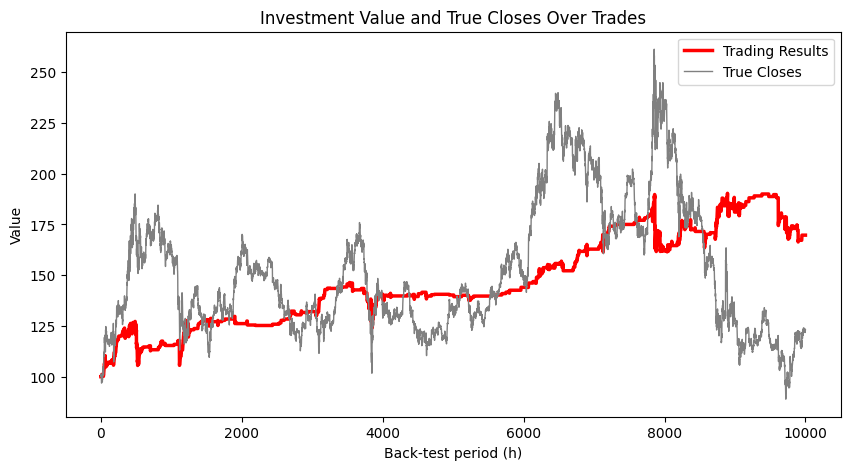

In [15]:
import matplotlib.pyplot as plt

# --- Constants ---
MINIMUM_PROBABILITY = 0.7
LEVERAGE = 1
FEE = 0.0
GAIN = 0.5 - FEE  # Interpreted as a percentage (e.g., 0.5% if multiplied by /100)


# --- Tracking variables ---
correct_trades = 0
total_trades = 0
bad_trades = []
all_trades = []

initial_investment = 100
current_investment = initial_investment
investment_history = []

# Go through probabilities alongside their index
for idx, prob in enumerate(validation_probabilities[1].to_list()):
    
    # Check if the predicted probability meets the threshold
    if prob >= MINIMUM_PROBABILITY:
        total_trades += 1
        
        # Check if the prediction was correct
        if validation_predictions["Label"][idx] == validation_dataset["Label"][idx]:
            correct_trades += 1
            
            # Record the "gain" in your trade list
            all_trades.append(GAIN * LEVERAGE)
            
            # Update current_investment by a factor of (1 + gain%)
            current_investment *= 1 + (GAIN / 100 * LEVERAGE)
        
        else:
            # Grab the next close price; watch out for index out-of-range in real code
            true_close = (validation_dataset[f"{TICKER}:close4"][idx + 1]) - FEE
            
            # Record the trade details
            bad_trades.append(round(true_close * LEVERAGE, 3))
            all_trades.append(true_close * LEVERAGE)

            # Update current_investment by (1 + some factor of true_close?)
            current_investment *= 1 + (true_close / 100 * LEVERAGE)
    
    else:
        all_trades.append(0)

    # In all cases, record the current investment amount
    investment_history.append(current_investment)

# --- After the loop, calculate stats ---
wrong_trades = total_trades - correct_trades
win_rate = (correct_trades / total_trades * 100) if total_trades else 0
total_return = current_investment - initial_investment

# --- Print results ---
#print(f"CORRECT: {correct_trades}")
#print(f"WRONG: {wrong_trades}")
print(f"NUMBER OF TRADES: {total_trades}")
print(f"ACCURACY: {round(win_rate, 2)}%")
print(f"RETURN: {round(total_return, 2)}%")
#print(f"INVESTMENT VALUE: {round(current_investment, 2)}")
print(f"SHARP RATIO: {calculate_sharpe_ratio(all_trades)}")
sharpe_ratio9999 = calculate_sharpe_ratio(validation_dataset[f"{TICKER}:close4"].to_list())
print(f"SHARP RATIO ONLY HOLDING ASSET: {sharpe_ratio9999}")
print(f"MEAN RETURN BAD TRADES: {st.mean(bad_trades)}")
print("-" * 34)

# Print information about bad trades
for trade in bad_trades:
    print(trade)

# --- Plot the investment history ---
true_closes_list = validation_dataset[f"{TICKER}:close4"].to_list()
true_close_base = 100
true_close_base_list = []

for close in true_closes_list:
    true_close_base *= 1 + (close / 100)
    true_close_base_list.append(true_close_base)


plt.figure(figsize=(10,5))
plt.plot(investment_history, label="Trading Results", color='red', linewidth=2.5)
plt.plot(true_close_base_list, label="True Closes", color='gray', linewidth=1)
plt.xlabel("Back-test period (h)")
plt.ylabel("Value")
plt.title("Investment Value and True Closes Over Trades")
plt.legend()
plt.show()

In [ ]:
############### ANALYSIS OF TRADING USING CLOSING PRICE ################################

# --- Constants ---
MINIMUM_PROBABILITY = 0.8
TRADING_FEE = 0.25

# --- Tracking variables ---
correct_trades = 0
total_trades = 0
wrong_trades = 0

all_trades = []
good_trades = []
bad_trades = []

# Go through probabilities alongside their index
for idx, prob in enumerate(validation_probabilities[1].to_list()):
    
    # Check if the predicted probability meets the threshold
    if prob >= MINIMUM_PROBABILITY:
        true_close = validation_dataset[f"{TICKER}:close4"][idx + 1] - TRADING_FEE
        
        if true_close >= 0:
            correct_trades += 1
            good_trades.append(true_close)
        else:
            bad_trades.append(true_close)



        total_trades += 1
        all_trades.append(true_close)
            

# --- After the loop, calculate stats ---
wrong_trades = total_trades - correct_trades
win_rate = (correct_trades / total_trades * 100) if total_trades else 0

# --- Print results ---
print(f"CORRECT: {correct_trades}")
print(f"WRONG: {wrong_trades}")
print(f"NUMBER OF TRADES: {total_trades}")
print(f"WIN RATE: {round(win_rate, 2)}%")
print("-" * 34)

print(f"MEAN GOOD TRADES: {st.mean(good_trades)}")
print(f"MEAN BAD TRADES: {st.mean(bad_trades)}")

investtt = 100
investment_history2 = []
for trade in all_trades:
    investtt *= 1 + (trade / 100)
    investment_history2.append(investtt)
    # print(trade)

print(f"RETURN: {round(investtt - 100, 3)} %")

# --- Plot the investment history ---
plt.plot(investment_history2)
plt.xlabel("Trade Index")
plt.ylabel("Investment Value")
plt.title("Investment Value Over Trades")
plt.show()

In [ ]:
############### ANALYSIS OF TRADING USING CLOSING PRICE ################################

# --- Constants ---
MINIMUM_PROBABILITY = 0.8
TRADING_FEE = 0.25
LEVERAGE = 1

# --- Tracking variables ---
correct_trades = 0
total_trades = 0
wrong_trades = 0

all_trades = []
good_trades = []
bad_trades = []
investment_value = 100
investment_history = []


# Go through probabilities alongside their index
for idx, prob in enumerate(validation_probabilities[1].to_list()):
    
    # Check if the predicted probability meets the threshold
    if prob >= MINIMUM_PROBABILITY:
        true_close = (validation_dataset[f"{TICKER}:close4"][idx + 1] - TRADING_FEE) * LEVERAGE
        
        if true_close >= 0:
            correct_trades += 1
            good_trades.append(true_close)
        else:
            bad_trades.append(true_close)



        total_trades += 1
        all_trades.append(true_close)

        investment_value *= 1 + (true_close / 100)
        investment_history.append(investment_value)
    
    else:
        investment_history.append(investment_value)

            

# --- After the loop, calculate stats ---
wrong_trades = total_trades - correct_trades
win_rate = (correct_trades / total_trades * 100) if total_trades else 0

# --- Print results ---
print(f"CORRECT: {correct_trades}")
print(f"WRONG: {wrong_trades}")
print(f"NUMBER OF TRADES: {total_trades}")
print(f"WIN RATE: {round(win_rate, 2)}%")
print("-" * 34)

print(f"MEAN GOOD TRADES: {st.mean(good_trades)}")
print(f"MEAN BAD TRADES: {st.mean(bad_trades)}")
print(f"INVESTMENT VALUE {investment_value}")

# investtt = 100
# investment_history2 = []
# for trade in all_trades:
#     investtt *= 1 + (trade / 100)
#     investment_history2.append(investtt)
#     # print(trade)

# print(f"RETURN: {round(investtt - 100, 3)} %")


from matplotlib import pyplot as plt
# --- Plot the investment history ---


plt.plot(investment_history)
plt.xlabel("Trade Index")
plt.ylabel("Investment Value")
plt.title("Investment Value Over Trades")
plt.show()